# Module: Compute CSF flux

> Combining SSPs to get Composite Stellar Population (CSP)

In [ ]:
#| default_exp calculate_csp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from watercolor.ssp_interpolation import spec_ssp_lookup

from watercolor.load_sps_library import load_fsps_spectral_library, load_fsps_age_metallicity
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE

from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.load_sim_stellar_catalog import GALS_FILE
from watercolor.load_sim_stellar_catalog import Z_SOLAR_PADOVA, H0

In [ ]:
#| hide

import matplotlib.pylab as plt

In [ ]:
#| export

def total_luminosity(spec_flux_ssp:np.ndarray, # SSP SEDs   
                     spec_wave:np.array # SED Wavelength
                    )-> np.float32: #Luminosity
    flux_proxy = np.trapz(spec_flux_ssp, spec_wave, axis=1) 
    return flux_proxy


def galaxy_stellar_mass(selected_star_masses:np.array #SSP masses in a galaxy
                       )-> np.float32: # Total stellar mass of the galaxy
    
    gal_stellar_mass = np.sum(selected_star_masses)
    return gal_stellar_mass


def ssp_to_csp(spec_flux_ssp:np.ndarray # SSP SEDs
              )-> np.array: #CSP SED
    spec_csp = np.sum(spec_flux_ssp, axis=0) ## CSP
    return spec_csp

In [ ]:
#| export

def calc_fluxes_for_galaxy(gal_file_in:str=GALS_FILE, # HACC stellar catalog
                           unique_gal_tag:np.float32=None, # Selected galaxy tag
                           spectral_library_flux:str=LIBRARY_FLUX_FILE, # Fluxes in the spectral library,
                           spectral_library_wave:str=LIBRARY_WAVE_FILE, # Wavelengths in the spectral library,
                           spectral_library_age:str=LIBRARY_AGE_FILE, # Age in the spectral library,
                           spectral_library_metal:str=LIBRARY_METAL_FILE, # Metallicity in the spectral library,
                          )->tuple: # SED wavelength, individual SSP SEDs, CSP SED, Luminosity, Galaxy stellar mass  
    
    spec_flux_library, spec_wave_library = load_fsps_spectral_library(spectral_library_flux, spectral_library_wave)
    age_fsps_gyr, Z_padova_fsps = load_fsps_age_metallicity(spectral_library_age, spectral_library_metal)
    gal_tags, _, metal_hydro, mass, age_hydro, _, _, _, _, _, _ = load_hacc_galaxy_data(gal_file_in)


    gal_tag_cond = np.where(gal_tags == unique_gal_tag)

    spec_flux_ssp = np.zeros( shape=(gal_tag_cond[0].shape[0], spec_wave_library.shape[0]))

    for idx, ssp_id in enumerate(gal_tag_cond[0]):    
        spec_wave_ssp, spec_flux_ssp[idx] = spec_ssp_lookup(age_hydro[ssp_id], 
                                                            metal_hydro[ssp_id], 
                                                            mass[ssp_id],
                                                            age_fsps_gyr,
                                                            Z_padova_fsps,
                                                            spec_flux_library,
                                                            spec_wave_library)

    spec_csp = ssp_to_csp(spec_flux_ssp)
    flux_proxy = total_luminosity(spec_flux_ssp, spec_wave_library) 
    gal_stellar_mass = galaxy_stellar_mass(mass[gal_tag_cond])

    return spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass 

In [ ]:
#| hide

gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()


In [ ]:
#| hide

gal_id = 2
unique_gal_tag = np.unique(gal_tag)[gal_id]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(
    GALS_FILE, 
    unique_gal_tag,
    LIBRARY_FLUX_FILE,
    LIBRARY_WAVE_FILE,
    LIBRARY_AGE_FILE,
    LIBRARY_METAL_FILE)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


(100.0, 1000.0)

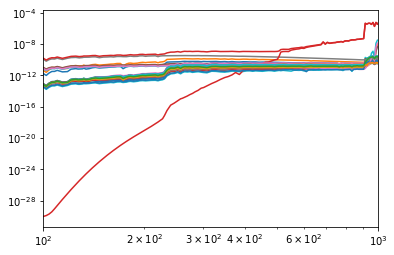

In [ ]:
#| hide

plt.figure()
plt.plot(spec_wave_ssp, spec_flux_ssp.T)
plt.plot(spec_wave_ssp, spec_csp)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e3)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()